# Sinulator

## 1. Setup & Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 2. Pop Params

Metro cities and 2026 populations are extracted directly from the file. Country growth rates are applied to project forward. Non-metro population = country overall − sum of metro cities.

In [14]:
import openpyxl

wb = openpyxl.load_workbook('1.1_Ty.xlsx', data_only=True)
country_sheet = wb['Country']
city_sheet = wb['City']

metro_rows = []
country_stats = {}

# Extract country statistics
for row in country_sheet.iter_rows(min_row=2, values_only=True):
    stat_country, metro_stat, nonmetro_stat, overall_stat, gr = row[0], row[1], row[2], row[3], row[4]
    if isinstance(stat_country, str) and isinstance(overall_stat, (int, float)) and gr is not None:
        country_stats[stat_country] = {
            'metro_pop_2026': metro_stat,
            'nonmetro_pop_2026': nonmetro_stat,
            'overall_pop_2026': overall_stat,
            'growth_rate': gr
        }

# Extract metro cities
current_country = None
for row in city_sheet.iter_rows(values_only=True):
    country_col, city_col, pop_col = row[0], row[1], row[2]
    if isinstance(country_col, str):
        current_country = country_col
    if current_country and isinstance(city_col, str) and isinstance(pop_col, (int, float)):
        metro_rows.append({'Country': current_country, 'City': city_col, 'Pop_2026': int(pop_col)})

metro_df = pd.DataFrame(metro_rows)
country_stats_df = pd.DataFrame(country_stats).T.reset_index().rename(columns={'index': 'Country'})
country_stats_df[['metro_pop_2026', 'nonmetro_pop_2026', 'overall_pop_2026', 'growth_rate']] = \
    country_stats_df[['metro_pop_2026', 'nonmetro_pop_2026', 'overall_pop_2026', 'growth_rate']].apply(pd.to_numeric)

In [15]:
# Project populations 2027-2034
YEARS = list(range(2027, 2035))

# Metro projections
metro_df = metro_df.merge(country_stats_df[['Country', 'growth_rate']], on='Country', how='left')
for yr in YEARS:
    n = yr - 2026
    metro_df[f'Pop_{yr}'] = (metro_df['Pop_2026'] * (1 + metro_df['growth_rate'])**n).round(0).astype(int)

# Non-metro projections
metro_sum = metro_df.groupby('Country')[[f'Pop_{yr}' for yr in YEARS]].sum().reset_index()
metro_sum = metro_sum.rename(columns={f'Pop_{yr}': f'MetroSum_{yr}' for yr in YEARS})

nonmetro_df = country_stats_df.copy()
for yr in YEARS:
    n = yr - 2026
    nonmetro_df[f'OverallPop_{yr}'] = (nonmetro_df['overall_pop_2026'] * (1 + nonmetro_df['growth_rate'])**n).round(0)

nonmetro_df = nonmetro_df.merge(metro_sum, on='Country', how='left')
for yr in YEARS:
    nonmetro_df[f'NonMetroPop_{yr}'] = (nonmetro_df[f'OverallPop_{yr}'] - nonmetro_df[f'MetroSum_{yr}']).clip(lower=0).round(0)

print('Metro (first 5):')
print(metro_df[['Country', 'City', 'Pop_2026', 'Pop_2027', 'Pop_2028']].head())
print('\nNon-Metro (first 5):')
print(nonmetro_df[['Country', 'NonMetroPop_2027', 'NonMetroPop_2028']].head())

Metro (first 5):
   Country       City  Pop_2026  Pop_2027  Pop_2028
0  Belgium   Brussels   2150320   2153330   2156345
1  Belgium    Antwerp   1068660   1070156   1071654
2  Belgium      Liege    690769    691736    692705
3  Belgium       Gent    480931    481604    482279
4  Belgium  Charleroi    420510    421099    421688

Non-Metro (first 5):
       Country  NonMetroPop_2027  NonMetroPop_2028
0      Belgium         6973159.0         6982921.0
1      Germany        58518166.0        58219725.0
2  Netherlands        14010356.0        14210705.0
3      Denmark         4400797.0         4425440.0
4      Estonia          875401.0          878464.0


## 3. Demand Parameters 

In [16]:
# Market entry years
ENTRY_YEAR = {
    'Belgium': 2027, 'Germany': 2027, 'Luxembourg': 2027, 'Netherlands': 2027,
    'Denmark': 2028, 'Estonia': 2028, 'Finland': 2028, 'Latvia': 2028,
    'Lithuania': 2028, 'Norway': 2028, 'Poland': 2028, 'Sweden': 2028,
    'Austria': 2029, 'France': 2029, 'Ireland': 2029, 'Italy': 2029,
    'Portugal': 2029, 'Spain': 2029, 'Switzerland': 2029,
    'Bulgaria': 2030, 'Croatia': 2030, 'Cyprus': 2030, 'Czech Republic': 2030,
    'Greece': 2030, 'Hungary': 2030, 'Malta': 2030, 'Romania': 2030,
    'Slovakia': 2030, 'Slovenia': 2030
}

# Adoption rate functions (triangular basis)
def adoption_rate_mp(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.00025
    if market_year == 1: return base
    base += 0.0002
    if market_year == 2: return base
    base += 0.0001
    if market_year == 3: return base
    return base + (market_year - 3) * 0.00005

def adoption_rate_opt(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0005
    if market_year == 1: return base
    base += 0.00025
    if market_year == 2: return base
    base += 0.0002
    if market_year == 3: return base
    return base + (market_year - 3) * 0.0001

def adoption_rate_pes(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0002
    if market_year == 1: return base
    base += 0.0001
    if market_year == 2: return base
    base += 0.00005
    if market_year == 3: return base
    return max(0, base + (market_year - 3) * (-0.00002))

# Day-of-week and period parameters
DOW_WEIGHTS = np.array([0.12, 0.12, 0.23, 0.25, 0.15, 0.10, 0.03])  # Mon-Sun
PERIOD_SHARES_BASE = np.array([0.05, 0.07, 0.09, 0.09, 0.09, 0.05, 0.04,
                                0.06, 0.13, 0.09, 0.06, 0.07, 0.11])
PERIOD_CV = 0.25
CYBER_WEEK_SHARE = 0.15
CYBER_PRICE_DISCOUNT = 0.15

In [17]:
# MyBot models
MODELS = [
    ('F10', 'Floor Care', 10, 360, 0.17),
    ('K10', 'Kitchen Help', 10, 360, 0.13),
    ('S10', 'Safety & Security', 10, 360, 0.10),
    ('W10', 'Wall & Window', 10, 360, 0.09),
    ('F20', 'Floor Care', 20, 480, 0.08),
    ('K20', 'Kitchen Help', 20, 480, 0.06),
    ('L20', 'Leisure', 20, 480, 0.05),
    ('S20', 'Safety & Security', 20, 480, 0.05),
    ('W20', 'Wall & Window', 20, 480, 0.04),
    ('X20', 'Exterior Care', 20, 480, 0.04),
    ('F30', 'Floor Care', 30, 600, 0.04),
    ('K30', 'Kitchen Help', 30, 600, 0.03),
    ('L30', 'Leisure', 30, 600, 0.03),
    ('S30', 'Safety & Security', 30, 600, 0.03),
    ('W30', 'Wall & Window', 30, 600, 0.02),
    ('X30', 'Exterior Care', 30, 600, 0.02),
    ('F50', 'Floor Care', 50, 720, 0.02),
    ('K50', 'Kitchen Help', 50, 720, 0.02),
    ('L50', 'Leisure', 50, 720, 0.01),
    ('S50', 'Safety & Security', 50, 720, 0.01),
    ('W50', 'Wall & Window', 50, 720, 0.01),
    ('X50', 'Exterior Care', 50, 720, 0.01),
    ('L10', 'Leisure', 10, 360, 0.02),
    ('X10', 'Exterior Care', 10, 360, 0.02),
]

model_df = pd.DataFrame(MODELS, columns=['Model', 'Category', 'Level', 'Price_EUR', 'Share_MP'])
model_df['Share_MP'] = model_df['Share_MP'] / model_df['Share_MP'].sum()

## 4. Calendar Builder

In [18]:
def first_monday_of_year(year: int) -> date:
    d = date(year, 1, 1)
    days_ahead = (7 - d.weekday()) % 7
    if days_ahead == 0:
        return d
    return d + timedelta(days=days_ahead) # add a date to move the date on calendar forwards

def black_friday(year: int) -> date:
    nov1 = date(year, 11, 1)
    days_to_friday = (4 - nov1.weekday()) % 7
    first_fri = nov1 + timedelta(days=days_to_friday)
    return first_fri + timedelta(weeks=3)

def cyber_week_dates(year: int):
    bf = black_friday(year)
    return {bf + timedelta(days=d) for d in range(4)}

def build_year_calendar(year: int) -> pd.DataFrame:
    start = date(year, 1, 1)
    end = date(year, 12, 31)
    days = [start + timedelta(days=i) for i in range((end - start).days + 1)]
    
    period_start = first_monday_of_year(year)
    cw = cyber_week_dates(year)
    
    records = []
    for d in days:
        delta = (d - period_start).days
        if delta >= 0:
            period = delta // 28 + 1
            period = min(period, 13)
        else:
            period = 1
        records.append({
            'date': d,
            'year': year,
            'day_of_week': d.weekday(),
            'period': period,
            'is_cyber_week': d in cw # returns boolean variable
        })
    return pd.DataFrame(records)


## 5. OTD Probability Table & Conversion Functions

In [19]:
# OTD probability lookup table 
OTD_PROB_TABLE = {
    'Metro': [
        (0, 0, 1.00),      
        (1, 1, 0.95),     
        (2, 2, 0.85),     
        (3, 4, 0.65),      
        (5, 7, 0.40),     
        (8, 15, 0.20),    
        (16, 30, 0.10),    
        (31, 60, 0.05),    
    ],
    'Non-Metro': [
        (0, 0, 1.00),
        (1, 1, 0.995),
        (2, 2, 0.98),
        (3, 4, 0.90),
        (5, 7, 0.70),
        (8, 15, 0.30),
        (16, 30, 0.15),
        (31, 60, 0.075),
    ]
}

def get_otd_conversion_rate(segment: str, otd_days: float) -> float:
    """Get conversion rate using interval-based lookup with interpolation."""
    table = OTD_PROB_TABLE[segment]
    
    # Find matching interval
    for min_days, max_days, conv_rate in table:
        if min_days <= otd_days <= max_days:
            return conv_rate
    
    # Out of range cases
    if otd_days < table[0][0]:
        return table[0][2]
    if otd_days > table[-1][1]:
        return table[-1][2]
    
    # Between intervals: interpolate
    for i in range(len(table) - 1):
        min1, max1, rate1 = table[i]
        min2, max2, rate2 = table[i + 1]
        mid1 = (min1 + max1) / 2.0
        mid2 = (min2 + max2) / 2.0
        if max1 < otd_days < min2:
            t = (otd_days - mid1) / (mid2 - mid1)
            return rate1 + t * (rate2 - rate1)
    
    return 0.0

print('Interval-based OTD table loaded')
print(f'Metro 2-day: {get_otd_conversion_rate("Metro", 2):.1%}')
print(f'Non-Metro 5-day: {get_otd_conversion_rate("Non-Metro", 5):.1%}')

Interval-based OTD table loaded
Metro 2-day: 85.0%
Non-Metro 5-day: 70.0%


## 6. Stochastic Number Generation Function

In [20]:
def triangular_adoption_rate(market_year: int, sim: int, yr: int) -> float:
    """
    Draw annual adoption rate from Triangular distribution.
    Fresh seed per (year, sim) for independent draws.
    """
    a = adoption_rate_pes(market_year)
    c = adoption_rate_mp(market_year)
    b = adoption_rate_opt(market_year)
    
    if a >= b:
        return c
    c = np.clip(c, a + 1e-12, b - 1e-12)
    
    seed = int(yr) * 100_000 + int(sim) * 13
    rng = np.random.default_rng(seed)
    return float(rng.triangular(left=a, mode=c, right=b))

def triangular_model_shares(model_shares_base: np.ndarray, sim: int, yr: int, spread: float = 0.20) -> np.ndarray:
    """
    Draw 24-model share vector from Triangular distribution.
    Renormalized to sum=1.
    """
    a = model_shares_base * (1.0 - spread)
    c = model_shares_base
    b = model_shares_base * (1.0 + spread)
    
    seed = int(yr) * 100_000 + int(sim) * 13 + 7
    rng = np.random.default_rng(seed)
    
    draws = rng.triangular(left=a, mode=c, right=b)
    draws = np.clip(draws, 1e-9, None)
    return draws / draws.sum()

def simulate_period_shares(n_sim: int = 1, seed: int = None) -> np.ndarray:
    """
    Draw period shares from Normal(base, CV*base).
    Returns shape (n_sim, 13).
    """
    rng = np.random.default_rng(seed)
    mu = PERIOD_SHARES_BASE
    std = PERIOD_CV * mu
    draws = rng.normal(loc=mu, scale=std, size=(n_sim, 13))
    draws = np.clip(draws, 1e-6, None)
    return draws / draws.sum(axis=1, keepdims=True)

## 7. Core Simulator — Aggregate Demand with OTD Conversion

### Modified pipeline:
1. Compute annual demand by segment (metro/non-metro) using triangular adoption rates
2. Allocate to daily **aggregate demand** by segment, day, and Cyber Week status
3. **Apply OTD conversion** at aggregate level for all product lines in daily basis → **CV sales**
4. Decompose aggregate sales to 24 products using triangular model shares

This avoids the explosion in output size from applying conversion at product level.

In [21]:
import gc, os

def run_otd_simulator(
    metro_df: pd.DataFrame,
    nonmetro_df: pd.DataFrame,
    model_df: pd.DataFrame,
    entry_year_map: dict,
    years: list,
    metro_city_otd: dict,
    nonmetro_otd: dict,
    n_sim: int = 1,
    seed: int = 42,
    batch_size: int = None,   # flush to disk every batch_size sims; None = old in-memory behaviour
    out_dir: str = None,      # directory for batch_*.csv.gz files (required when batch_size set)
) -> pd.DataFrame:
    """
    OTD simulator with optional batched-flush mode.

    When batch_size + out_dir are provided:
      - sim_records is cleared after every batch_size sims (constant memory)
      - each batch is aggregated to (sim, date, model, sales_units) and saved as
        {out_dir}/batch_{i:02d}.csv.gz  (gzip-compressed CSV, no extra dependencies)
      - returns dict{'annual_summary': ..., 'segment_summary': ...}  (both tiny)
    Otherwise:
      - legacy behaviour: accumulate all records and return a single DataFrame
    """
    use_batched = (batch_size is not None) and (out_dir is not None)
    if use_batched:
        os.makedirs(out_dir, exist_ok=True)

    rng_global = np.random.default_rng(seed)
    model_shares_base = model_df['Share_MP'].values
    model_codes       = model_df['Model'].values
    model_prices      = model_df['Price_EUR'].values

    sim_records      = []
    annual_records   = []   # (sim, year) tiny summaries across batches
    segment_records  = []   # (sim, year, segment) tiny summaries across batches

    for sim in range(n_sim):
        print(f'  Sim {sim+1}/{n_sim}...', end=' ', flush=True)

        for yr in years:
            cal    = build_year_calendar(yr)
            cw_days  = cal[cal['is_cyber_week']]['date'].values
            ncw_days = cal[~cal['is_cyber_week']]
            n_cw   = len(cw_days)

            # ── 1. Annual demand aggregated by country-segment ──
            segment_annual = {}

            for _, city_row in metro_df.iterrows():
                country = city_row['Country']
                if country not in entry_year_map: continue
                market_year = yr - entry_year_map[country] + 1
                if market_year < 1: continue
                pop  = city_row[f'Pop_{yr}']
                rate = triangular_adoption_rate(market_year, sim, yr)
                key  = (country, 'Metro')
                segment_annual[key] = segment_annual.get(key, 0) + pop * rate

            for _, nm_row in nonmetro_df.iterrows():
                country = nm_row['Country']
                if country not in entry_year_map: continue
                market_year = yr - entry_year_map[country] + 1
                if market_year < 1: continue
                pop  = nm_row[f'NonMetroPop_{yr}']
                rate = triangular_adoption_rate(market_year, sim, yr)
                segment_annual[(country, 'Non-Metro')] = pop * rate

            if not segment_annual: continue
            total_annual = sum(segment_annual.values())
            if total_annual == 0: continue

            # ── 2. Period shares ──
            period_shares = simulate_period_shares(
                n_sim=1, seed=int(rng_global.integers(0, 1_000_000)))[0]

            # ── 3. Cyber vs regular split ──
            cyber_total   = total_annual * CYBER_WEEK_SHARE
            regular_total = total_annual * (1.0 - CYBER_WEEK_SHARE)

            # ── 4. Daily demand allocation ──
            day_demand_total = {}
            for p in range(1, 14):
                period_units = regular_total * period_shares[p - 1]
                p_days = ncw_days[ncw_days['period'] == p]
                if len(p_days) == 0: continue
                dow_w = p_days['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                dow_w = dow_w / dow_w.sum()
                for d_idx, (_, day_row) in enumerate(p_days.iterrows()):
                    day_demand_total[day_row['date']] = period_units * dow_w[d_idx]

            if n_cw > 0:
                cw_cal   = cal[cal['is_cyber_week']]
                cw_dow_w = cw_cal['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                cw_dow_w = cw_dow_w / cw_dow_w.sum()
                for i, (_, cw_row) in enumerate(cw_cal.iterrows()):
                    day_demand_total[cw_row['date']] = cyber_total * cw_dow_w[i]

            # ── 5. Segment weights & city-level OTD ──
            segment_weights = {k: v / total_annual for k, v in segment_annual.items()}
            cw_date_set     = {pd.Timestamp(x).date() if not isinstance(x, date) else x
                               for x in cw_days}

            country_metro_otd_yr = {}
            for _, city_row in metro_df.iterrows():
                country  = city_row['Country']
                city     = city_row['City']
                pop      = city_row[f'Pop_{yr}']
                city_otd = metro_city_otd.get(city, {}).get(yr, 2.0)
                if country not in country_metro_otd_yr:
                    country_metro_otd_yr[country] = {'weighted_sum': 0.0, 'total_pop': 0.0}
                country_metro_otd_yr[country]['weighted_sum'] += city_otd * pop
                country_metro_otd_yr[country]['total_pop']    += pop
            for country in country_metro_otd_yr:
                tp = country_metro_otd_yr[country]['total_pop']
                country_metro_otd_yr[country] = (
                    country_metro_otd_yr[country]['weighted_sum'] / tp if tp > 0 else 2.0)

            # ── 6. OTD conversion at aggregate level ──
            daily_segment_sales = {}
            for d, total_units in day_demand_total.items():
                is_cw = d in cw_date_set
                for (country, segment), seg_weight in segment_weights.items():
                    seg_demand = total_units * seg_weight
                    if segment == 'Metro':
                        otd_days = country_metro_otd_yr.get(country, 2.0)
                    else:
                        otd_days = nonmetro_otd.get(country, {}).get(yr, 5.0)
                    conversion_rate = get_otd_conversion_rate(segment, otd_days)
                    daily_segment_sales[(d, country, segment, is_cw)] = {
                        'demand': seg_demand,
                        'sales':  seg_demand * conversion_rate,
                        'otd_days': otd_days,
                        'conversion_rate': conversion_rate,
                    }

            # ── 7. Decompose to 24 products ──
            model_shares = triangular_model_shares(model_shares_base, sim, yr)
            for (d, country, segment, is_cw), agg in daily_segment_sales.items():
                ms_vec  = agg['sales']  * model_shares
                md_vec  = agg['demand'] * model_shares
                p_factor = (1.0 - CYBER_PRICE_DISCOUNT) if is_cw else 1.0
                for m_idx, mdl in enumerate(model_codes):
                    ms = ms_vec[m_idx]
                    if ms < 1e-9: continue
                    sim_records.append({
                        'sim':             sim,
                        'date':            pd.Timestamp(d),
                        'year':            yr,
                        'country':         country,
                        'segment':         segment,
                        'is_cyber_week':   is_cw,
                        'demand_units':    md_vec[m_idx],
                        'otd_days':        agg['otd_days'],
                        'conversion_rate': agg['conversion_rate'],
                        'sales_units':     ms,
                        'model':           mdl,
                        'revenue':         ms * model_prices[m_idx] * p_factor,
                    })

        print('Done')

        # ── Batch flush: aggregate & write gzip CSV, then free memory ──
        if use_batched and (sim + 1) % batch_size == 0:
            batch_idx = (sim + 1) // batch_size - 1
            batch_df  = pd.DataFrame(sim_records)

            # (sim, date, model) demand — what Task3 needs
            demand_batch = (
                batch_df[['sim', 'date', 'model', 'sales_units']]
                .groupby(['sim', 'date', 'model'], as_index=False)
                .agg(sales_units=('sales_units', 'sum'))
            )
            out_path = os.path.join(out_dir, f'batch_{batch_idx:02d}.csv.gz')
            demand_batch.to_csv(out_path, index=False, compression='gzip')

            # Tiny annual accumulator
            annual_records.append(
                batch_df.groupby(['sim', 'year']).agg(
                    demand_units=('demand_units', 'sum'),
                    sales_units =('sales_units',  'sum'),
                    revenue     =('revenue',       'sum'),
                ).reset_index()
            )

            # Tiny segment accumulator
            segment_records.append(
                batch_df.groupby(['sim', 'year', 'segment']).agg(
                    demand_units=('demand_units', 'sum'),
                    sales_units =('sales_units',  'sum'),
                    otd_days    =('otd_days',      'mean'),
                ).reset_index()
            )

            del batch_df, demand_batch
            sim_records = []
            gc.collect()
            print(f'  [Batch {batch_idx:02d} flushed → {out_path}]', flush=True)

    # ── Return ──
    if use_batched:
        annual_summary  = pd.concat(annual_records,  ignore_index=True)
        segment_summary = pd.concat(segment_records, ignore_index=True)
        annual_summary['lost_units']      = (annual_summary['demand_units']
                                             - annual_summary['sales_units'])
        annual_summary['conversion_pct']  = (annual_summary['sales_units']
                                             / annual_summary['demand_units'] * 100)
        segment_summary['conversion_pct'] = (segment_summary['sales_units']
                                             / segment_summary['demand_units'] * 100)
        return {'annual_summary': annual_summary, 'segment_summary': segment_summary}
    else:
        return pd.DataFrame(sim_records)

## 8. City OTD Params Retrieval

Load OTD data from assignment CSV file with year-specific values

In [22]:
# ==================== LOAD OTD DATA FROM CSV ====================
# Load the assignment data with OTD values
otd_data = pd.read_csv('assignment_with_otd_prob_reachable.csv')

print(f'Loaded OTD data: {len(otd_data)} rows')
print(f'Years covered: {sorted(otd_data["year"].unique())}')
print(f'Node types: {otd_data["node_type"].value_counts().to_dict()}')

# Country code mapping (ISO 2-letter to full name)
COUNTRY_CODE_MAP = {
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'CH': 'Switzerland',
    'CY': 'Cyprus', 'CZ': 'Czech Republic', 'DE': 'Germany', 'DK': 'Denmark',
    'EE': 'Estonia', 'ES': 'Spain', 'FI': 'Finland', 'FR': 'France',
    'GR': 'Greece', 'HR': 'Croatia', 'HU': 'Hungary', 'IE': 'Ireland',
    'IT': 'Italy', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'LV': 'Latvia',
    'MT': 'Malta', 'NL': 'Netherlands', 'NO': 'Norway', 'PL': 'Poland',
    'PT': 'Portugal', 'RO': 'Romania', 'SE': 'Sweden', 'SI': 'Slovenia',
    'SK': 'Slovakia'
}

# Helper function to normalize city names (CSV format -> DataFrame format)
def normalize_city_name(csv_city_name):
    """
    Convert CSV city name format (e.g., 'frankfurt_am_main') 
    to DataFrame format (e.g., 'Frankfurt am Main')
    """
    # Split by underscore and title case each word
    words = csv_city_name.split('_')
    # Title case each word
    titled_words = [w.title() for w in words]
    return ' '.join(titled_words)

# Build metro_city_otd dictionary: {city_name: {year: otd_days}}
metro_city_otd = {}
metro_otd_df = otd_data[otd_data['node_type'] == 'metro'].copy()

for _, row in metro_otd_df.iterrows():
    # Parse node_id: "METRO_BE_brussels" -> country_code="BE", city="brussels"
    parts = row['node_id'].split('_')
    if len(parts) >= 3:
        country_code = parts[1]
        csv_city_name = '_'.join(parts[2:])  # Handle multi-word cities
        
        # Normalize city name to match metro_df format
        city_name = normalize_city_name(csv_city_name)
        
        year = int(row['year'])
        otd_days = float(row['otd_days_promise'])
        
        # Initialize city dict if needed
        if city_name not in metro_city_otd:
            metro_city_otd[city_name] = {}
        
        metro_city_otd[city_name][year] = otd_days

# Build country_nonmetro_otd dictionary: {country_name: {year: otd_days}}
country_nonmetro_otd = {}
nonmetro_otd_df = otd_data[otd_data['node_type'] == 'non_metro'].copy()

for _, row in nonmetro_otd_df.iterrows():
    # Parse node_id: "NONMETRO_BE" -> country_code="BE"
    parts = row['node_id'].split('_')
    if len(parts) >= 2:
        country_code = parts[1]
        
        # Map country code to full name
        country_name = COUNTRY_CODE_MAP.get(country_code, country_code)
        
        year = int(row['year'])
        otd_days = float(row['otd_days_promise'])
        
        # Initialize country dict if needed
        if country_name not in country_nonmetro_otd:
            country_nonmetro_otd[country_name] = {}
        
        country_nonmetro_otd[country_name][year] = otd_days

print(f'\nLoaded OTD for {len(metro_city_otd)} metro cities')
print(f'Loaded OTD for {len(country_nonmetro_otd)} non-metro countries')

# ==================== VALIDATION ====================
# 1. Check match with entry map
print('\n=== VALIDATION 1: Country Coverage ===')
countries_in_entry_map = set(ENTRY_YEAR.keys())
countries_with_nonmetro_otd = set(country_nonmetro_otd.keys())

missing_in_otd = countries_in_entry_map - countries_with_nonmetro_otd
extra_in_otd = countries_with_nonmetro_otd - countries_in_entry_map

if missing_in_otd:
    print(f'⚠️  Countries in ENTRY_YEAR but missing non-metro OTD: {missing_in_otd}')
else:
    print('✓ All countries in ENTRY_YEAR have non-metro OTD data')

if extra_in_otd:
    print(f'ℹ️  Extra countries with non-metro OTD (not in ENTRY_YEAR): {extra_in_otd}')

# 2. Check metro city matching
print('\n=== VALIDATION 2: Metro City Coverage ===')
cities_in_metro_df = set(metro_df['City'].unique())
cities_with_otd = set(metro_city_otd.keys())

missing_cities = cities_in_metro_df - cities_with_otd
extra_cities = cities_with_otd - cities_in_metro_df

print(f'Cities in metro_df: {len(cities_in_metro_df)}')
print(f'Cities with OTD data: {len(cities_with_otd)}')

if missing_cities:
    print(f'⚠️  Cities in metro_df missing OTD ({len(missing_cities)}): {list(missing_cities)[:10]}...')
else:
    print('✓ All cities in metro_df have OTD data')

if extra_cities:
    print(f'ℹ️  Extra cities with OTD not in metro_df ({len(extra_cities)}): {list(extra_cities)[:10]}...')

# 3. Check year coverage
print('\n=== VALIDATION 3: Year Coverage ===')
years_expected = set(YEARS)
years_in_otd = set()
for city_dict in metro_city_otd.values():
    years_in_otd.update(city_dict.keys())

if years_in_otd == years_expected:
    print(f'✓ OTD data covers all expected years: {sorted(years_expected)}')
else:
    missing_years = years_expected - years_in_otd
    extra_years = years_in_otd - years_expected
    if missing_years:
        print(f'⚠️  Missing years in OTD: {missing_years}')
    if extra_years:
        print(f'ℹ️  Extra years in OTD: {extra_years}')

# 4. Show sample OTD values
print('\n=== SAMPLE OTD VALUES ===')
sample_cities = list(metro_city_otd.keys())[:5]
for city in sample_cities:
    print(f'\n{city}:')
    for yr in [2027, 2030, 2034]:
        if yr in metro_city_otd[city]:
            print(f'  {yr}: {metro_city_otd[city][yr]:.2f} days')

sample_countries = list(country_nonmetro_otd.keys())[:3]
print('\nNon-Metro Countries:')
for country in sample_countries:
    print(f'\n{country}:')
    for yr in [2027, 2030, 2034]:
        if yr in country_nonmetro_otd[country]:
            print(f'  {yr}: {country_nonmetro_otd[country][yr]:.2f} days')

# 5. Statistics
print('\n=== OTD STATISTICS ===')
all_metro_otd = [v for city_dict in metro_city_otd.values() for v in city_dict.values()]
all_nonmetro_otd = [v for country_dict in country_nonmetro_otd.values() for v in country_dict.values()]

if all_metro_otd:
    print(f'Metro OTD: min={min(all_metro_otd):.2f}, max={max(all_metro_otd):.2f}, mean={sum(all_metro_otd)/len(all_metro_otd):.2f} days')
if all_nonmetro_otd:
    print(f'Non-Metro OTD: min={min(all_nonmetro_otd):.2f}, max={max(all_nonmetro_otd):.2f}, mean={sum(all_nonmetro_otd)/len(all_nonmetro_otd):.2f} days')


# ==================== ORIGINAL SYNTHETIC CODE (COMMENTED OUT) ====================
# # Generate city-level OTD for ALL 273 metro cities - YEAR-SPECIFIC (2027-2034)
# 
# # Structure: metro_city_otd[city][year] = otd_days
# # Structure: country_nonmetro_otd[country][year] = otd_days
# 
# metro_city_otd = {}
# country_nonmetro_otd = {}
# 
# # Base OTD assignment by population tier (for 2027)
# for _, row in metro_df.iterrows():
#     city = row['City']
#     pop = row['Pop_2026']
#     
#     # Assign base OTD based on population tiers
#     if pop >= 2_000_000:        # Very large cities
#         base_otd = 1.0
#     elif pop >= 1_000_000:      # Large cities
#         base_otd = 1.5
#     elif pop >= 500_000:        # Medium cities
#         base_otd = 2.0
#     elif pop >= 250_000:        # Small cities
#         base_otd = 2.5
#     else:                       # Very small metro cities
#         base_otd = 3.0
#     
#     # Generate year-specific OTD (improving over time)
#     # Assume logistics infrastructure improves: 3% reduction per year
#     metro_city_otd[city] = {}
#     for idx, yr in enumerate(YEARS):
#         improvement_factor = 0.97 ** idx  # 3% improvement per year
#         metro_city_otd[city][yr] = max(0.5, base_otd * improvement_factor)  # Floor at 0.5 days
# 
# # Generate country-level non-metro OTD by year
# rng1 = np.random.default_rng(42)  # Fixed seed for reproducibility
# 
# for country in nonmetro_df['Country'].unique():
#     base_nonmetro_otd = rng1.uniform(3.0, 6.0)  # Base OTD between 3-6 days
#     
#     country_nonmetro_otd[country] = {}
#     for idx, yr in enumerate(YEARS):
#         improvement_factor = 0.97 ** idx  # Same 3% improvement per year
#         country_nonmetro_otd[country][yr] = max(1.0, base_nonmetro_otd * improvement_factor)  # Floor at 1.0 day
# 
# print(f'Generated year-specific city-level OTD for {len(metro_city_otd)} metro cities')
# print(f'Generated year-specific country non-metro OTD for {len(country_nonmetro_otd)} countries')
# 
# # Show OTD evolution for sample cities
# print(f'\nSample Metro City OTD Evolution:')
# sample_cities = list(metro_city_otd.keys())[:5]
# for city in sample_cities:
#     print(f'  {city}:')
#     for yr in [2027, 2030, 2034]:
#         print(f'    {yr}: {metro_city_otd[city][yr]:.2f} days')
# 
# print(f'\nSample Non-Metro Country OTD Evolution:')
# sample_countries = list(country_nonmetro_otd.keys())[:3]
# for country in sample_countries:
#     print(f'  {country}:')
#     for yr in [2027, 2030, 2034]:
#         print(f'    {yr}: {country_nonmetro_otd[country][yr]:.2f} days')

Loaded OTD data: 1966 rows
Years covered: [2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034]
Node types: {'metro': 1786, 'non_metro': 180}

Loaded OTD for 272 metro cities
Loaded OTD for 29 non-metro countries

=== VALIDATION 1: Country Coverage ===
✓ All countries in ENTRY_YEAR have non-metro OTD data

=== VALIDATION 2: Metro City Coverage ===
Cities in metro_df: 272
Cities with OTD data: 272
⚠️  Cities in metro_df missing OTD (20): ['Hamburg-Nord', 'Frankfurt am Main', 'Castello de la Plana', 'Saint-Etienne', 'Fuencarral-El Pardo', 'Hamburg-Mitte', 'Gasteiz / Vitoria', 'Bochum-Hordel', 'Cergy-Pontoise', 'Cluj-Napoca']...
ℹ️  Extra cities with OTD not in metro_df (20): ['Las Palmas De Gran Canaria', 'Alcala De Henares', 'Puente De Vallecas', 'Fuencarral El Pardo', 'Gasteiz Vitoria', 'Sants Montjuic', 'Saint Etienne', 'Jerez De La Frontera', 'Frankfurt Am Main', 'Hamburg Mitte']...

=== VALIDATION 3: Year Coverage ===
✓ OTD data covers all expected years: [2027, 2028, 2029, 2030, 2031, 2

## 9. Run Simulation with Year-Specific OTD

Single scenario with year-specific OTD improvement (3% per year)

In [23]:
SIM_OUT_DIR = '../Task3/sim_batches'   # 20 × batch_*.csv.gz written here (100 reps / 5 per batch)
N_SIM       = 100
BATCH_SIZE  = 5   # max reps held in memory at once (device limit)

print(f'=== BATCH RUN: {N_SIM} reps  |  batch size = {BATCH_SIZE} ===\n')

summaries = run_otd_simulator(
    metro_df       = metro_df,
    nonmetro_df    = nonmetro_df,
    model_df       = model_df,
    entry_year_map = ENTRY_YEAR,
    years          = YEARS,
    metro_city_otd = metro_city_otd,
    nonmetro_otd   = country_nonmetro_otd,
    n_sim          = N_SIM,
    seed           = 42,
    batch_size     = BATCH_SIZE,
    out_dir        = SIM_OUT_DIR,
)

annual_summary  = summaries['annual_summary']
segment_summary = summaries['segment_summary']

print(f'\n=== All {N_SIM} simulations complete ===')
print(f'Annual summary rows : {len(annual_summary):,}')
print(f'Segment summary rows: {len(segment_summary):,}')
import glob as _glob
batch_files = sorted(_glob.glob(f'{SIM_OUT_DIR}/batch_*.csv.gz'))
print(f'Batch files written : {len(batch_files)}  →  {SIM_OUT_DIR}/')

=== BATCH RUN: 100 reps  |  batch size = 5 ===

  Sim 1/100... Done
  Sim 2/100... Done
  Sim 3/100... Done
  Sim 4/100... Done
  Sim 5/100... Done
  [Batch 00 flushed → ../Task3/sim_batches/batch_00.csv.gz]
  Sim 6/100... Done
  Sim 7/100... Done
  Sim 8/100... Done
  Sim 9/100... Done
  Sim 10/100... Done
  [Batch 01 flushed → ../Task3/sim_batches/batch_01.csv.gz]
  Sim 11/100... Done
  Sim 12/100... Done
  Sim 13/100... Done
  Sim 14/100... Done
  Sim 15/100... Done
  [Batch 02 flushed → ../Task3/sim_batches/batch_02.csv.gz]
  Sim 16/100... Done
  Sim 17/100... Done
  Sim 18/100... Done
  Sim 19/100... Done
  Sim 20/100... Done
  [Batch 03 flushed → ../Task3/sim_batches/batch_03.csv.gz]
  Sim 21/100... Done
  Sim 22/100... Done
  Sim 23/100... Done
  Sim 24/100... Done
  Sim 25/100... Done
  [Batch 04 flushed → ../Task3/sim_batches/batch_04.csv.gz]
  Sim 26/100... Done
  Sim 27/100... Done
  Sim 28/100... Done
  Sim 29/100... Done
  Sim 30/100... Done
  [Batch 05 flushed → ../Task3/

## Aggregate & Save for futher usage

aggregate in daily and product level acroos cities& cuntries and save for task3 usage

In [28]:
import glob as _glob

# ── Load all batch gzip-CSV files and compute per-(date, model) statistics ──
batch_files = sorted(_glob.glob(f'{SIM_OUT_DIR}/batch_*.csv.gz'))
print(f'Loading {len(batch_files)} batch files ({N_SIM} reps total)...')

all_batches = pd.concat(
    [pd.read_csv(f, compression='gzip') for f in batch_files],
    ignore_index=True
)

# Per-(date, model): distribution statistics across all 100 sims
demand_stats = (
    all_batches
    .groupby(['date', 'model'])['sales_units']
    .agg(
        mean = 'mean',
        std  = 'std',
        p05  = lambda x: x.quantile(0.05),
        p25  = lambda x: x.quantile(0.25),
        p50  = 'median',
        p75  = lambda x: x.quantile(0.75),
        p95  = lambda x: x.quantile(0.95),
    )
    .reset_index()
)

out_path = '../Task3/simulated_demand.csv.gz'
demand_stats.to_csv(out_path, index=False, compression='gzip')

del all_batches
gc.collect()

print(f'Saved demand_stats     : {len(demand_stats):,} rows  →  {out_path}')

# ── Also persist summaries so visualization section can run without re-running the simulation ──
annual_summary.to_csv('../Task3/annual_summary.csv.gz',   index=False, compression='gzip')
segment_summary.to_csv('../Task3/segment_summary.csv.gz', index=False, compression='gzip')
print(f'Saved annual_summary   : {len(annual_summary):,} rows  →  ../Task3/annual_summary.csv.gz')
print(f'Saved segment_summary  : {len(segment_summary):,} rows  →  ../Task3/segment_summary.csv.gz')

Loading 20 batch files (100 reps total)...
Saved demand_stats     : 70,128 rows  →  ../Task3/simulated_demand.csv.gz
Saved annual_summary   : 800 rows  →  ../Task3/annual_summary.csv.gz
Saved segment_summary  : 1,600 rows  →  ../Task3/segment_summary.csv.gz


In [29]:
# ── Annual statistics across 100 sims ──
# annual_summary / segment_summary already accumulated in memory during batching

annual_stats = annual_summary.groupby('year').agg(
    demand_units_mean =('demand_units', 'mean'),
    demand_units_std  =('demand_units', 'std'),
    demand_units_min  =('demand_units', 'min'),
    demand_units_max  =('demand_units', 'max'),
    sales_units_mean  =('sales_units',  'mean'),
    sales_units_std   =('sales_units',  'std'),
    lost_units_mean   =('lost_units',   'mean'),
    lost_units_std    =('lost_units',   'std'),
    conversion_pct_mean=('conversion_pct', 'mean'),
    conversion_pct_std =('conversion_pct', 'std'),
    conversion_pct_min =('conversion_pct', 'min'),
    conversion_pct_max =('conversion_pct', 'max'),
    revenue_mean      =('revenue',      'mean'),
    revenue_std       =('revenue',      'std'),
).reset_index()

annual_stats['revenue_M_mean'] = annual_stats['revenue_mean'] / 1e6
annual_stats['revenue_M_std']  = annual_stats['revenue_std']  / 1e6

print(f'=== Annual Summary Statistics (n_sim={N_SIM}) ===\n')
print(annual_stats[[
    'year', 'demand_units_mean', 'sales_units_mean', 'lost_units_mean',
    'conversion_pct_mean', 'conversion_pct_std', 'revenue_M_mean', 'revenue_M_std'
]].round(1).to_string(index=False))

# ── Segment-level ──
segment_stats = segment_summary.groupby(['year', 'segment']).agg(
    demand_units=('demand_units', 'sum'),
    sales_units =('sales_units',  'sum'),
    otd_days    =('otd_days',     'mean'),
).reset_index()
segment_stats['conversion_pct'] = (
    segment_stats['sales_units'] / segment_stats['demand_units'] * 100)

print('\n\n=== Conversion Rates by Segment ===\n')
segment_pivot = segment_stats.pivot_table(
    index='year', columns='segment', values='conversion_pct', aggfunc='mean').round(1)
print(segment_pivot.to_string())

print('\n\n=== Average OTD Days by Segment ===\n')
otd_pivot = segment_stats.pivot_table(
    index='year', columns='segment', values='otd_days', aggfunc='mean').round(2)
print(otd_pivot.to_string())

=== Annual Summary Statistics (n_sim=100) ===

 year  demand_units_mean  sales_units_mean  lost_units_mean  conversion_pct_mean  conversion_pct_std  revenue_M_mean  revenue_M_std
 2027            36104.3           35495.9            608.3                 98.3                 0.0            15.9            3.4
 2028            78516.8           76674.8           1842.1                 97.7                 0.0            34.3            6.8
 2029           173214.1          167044.4           6169.6                 96.4                 0.0            74.8           15.3
 2030           244646.6          236579.3           8067.3                 96.7                 0.0           106.0           20.7
 2031           289138.2          279220.1           9918.1                 96.6                 0.0           125.0           27.4
 2032           319672.5          308549.4          11123.0                 96.5                 0.0           138.3           32.9
 2033           320836.9     

## 10. Visualization Suite (Task 1.6 Analysis)

Single scenario analysis with year-specific OTD using heatmaps, time-series plots, and boxplots

In [30]:
import glob as _glob, os

# ════════════════════════════════════════════════════════════════════════════
# Load all simulation results from saved files.
# sim_df no longer exists (batch approach); everything is reconstructed here.
# ════════════════════════════════════════════════════════════════════════════

# ── 1. Batch files → viz_df: (sim, date, model, sales_units) + enrichment ──
batch_files = sorted(_glob.glob(f'{SIM_OUT_DIR}/batch_*.csv.gz'))
print(f'Loading {len(batch_files)} batch files...')
viz_df = pd.concat(
    [pd.read_csv(f, compression='gzip') for f in batch_files],
    ignore_index=True
)
viz_df['date'] = pd.to_datetime(viz_df['date'])
viz_df['year'] = viz_df['date'].dt.year

# Enrich with model metadata (Category, price, revenue)
model_info = model_df.set_index('Model')[['Category', 'Price_EUR']]
viz_df = viz_df.join(model_info, on='model')

cw_dates_all = set()
for yr in YEARS:
    cw_dates_all.update(pd.Timestamp(d) for d in cyber_week_dates(yr))
viz_df['is_cyber_week'] = viz_df['date'].isin(cw_dates_all)
viz_df['revenue'] = (
    viz_df['sales_units'] * viz_df['Price_EUR']
    * viz_df['is_cyber_week'].map({True: 1 - CYBER_PRICE_DISCOUNT, False: 1.0})
)
viz_df['tier'] = viz_df['model'].str.extract(r'(\d+)$').astype(int)

# ── 2. Summaries: annual and segment level ──
annual_summary  = pd.read_csv('../Task3/annual_summary.csv.gz',  compression='gzip')
segment_summary = pd.read_csv('../Task3/segment_summary.csv.gz', compression='gzip')

# ── 3. Rebuild heatmap pivots ──
segment_pivot = (
    segment_summary
    .groupby(['year', 'segment'])['conversion_pct']
    .mean().unstack().round(1)
)
otd_pivot = (
    segment_summary
    .groupby(['year', 'segment'])['otd_days']
    .mean().unstack().round(2)
)

os.makedirs('../Plots', exist_ok=True)

print(f'viz_df          : {len(viz_df):,} rows  |  {viz_df["sim"].nunique()} sims  '
      f'|  {viz_df["year"].min()}–{viz_df["year"].max()}')
print(f'annual_summary  : {len(annual_summary):,} rows')
print(f'segment_summary : {len(segment_summary):,} rows')

Loading 20 batch files...
viz_df          : 7,012,800 rows  |  100 sims  |  2027–2034
annual_summary  : 800 rows
segment_summary : 1,600 rows


### 10.1 Heatmap: Annual Metrics by Year and Segment

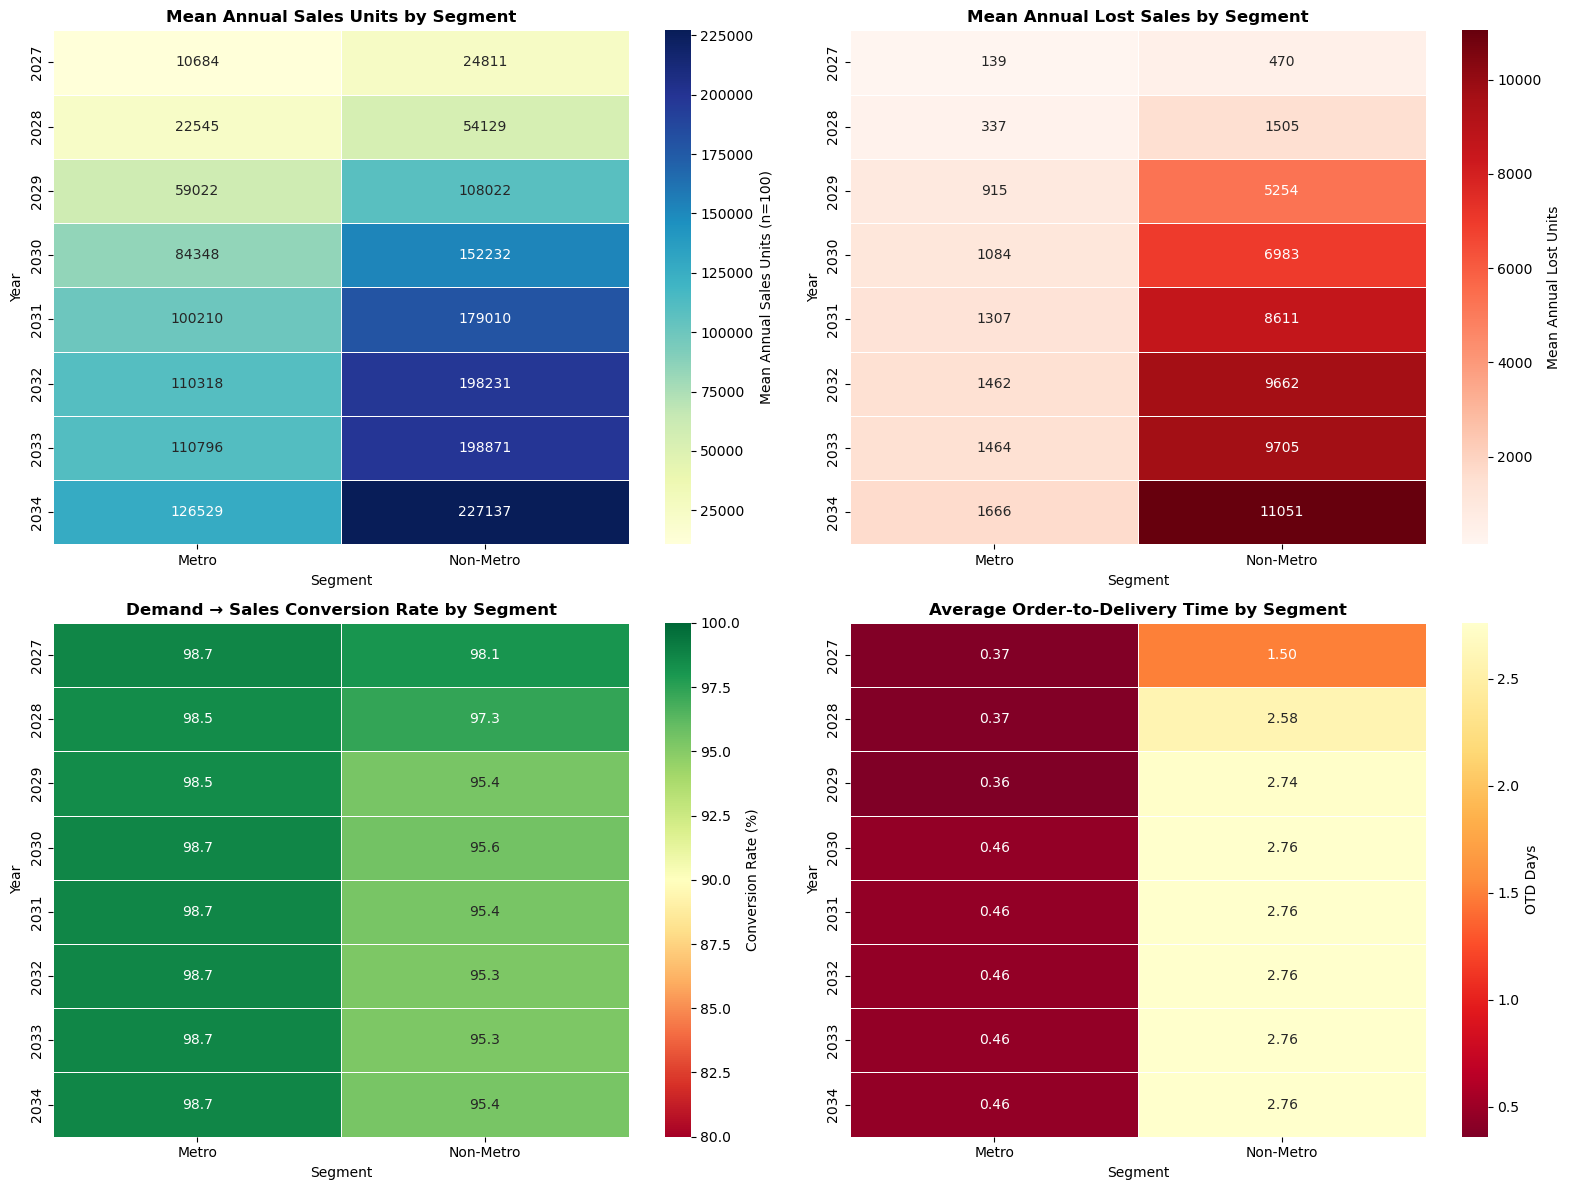

Saved: task1_heatmaps_by_segment.png


In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ── Aggregate segment data (mean across sims) from segment_summary ──
seg_stat = (
    segment_summary
    .assign(lost_units=lambda df: df['demand_units'] - df['sales_units'])
    .groupby(['year', 'segment'])
    .agg(sales_units=('sales_units', 'mean'),
         lost_units =('lost_units',  'mean'))
    .reset_index()
)

# Heatmap 1: Mean Annual Sales Units by Year × Segment
sales_heatmap = seg_stat.pivot(index='year', columns='segment', values='sales_units')
sns.heatmap(sales_heatmap, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0, 0],
            linewidths=0.5, cbar_kws={'label': f'Mean Annual Sales Units (n={N_SIM})'})
axes[0, 0].set_title('Mean Annual Sales Units by Segment', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Segment')
axes[0, 0].set_ylabel('Year')

# Heatmap 2: Mean Annual Lost Sales by Year × Segment
lost_heatmap = seg_stat.pivot(index='year', columns='segment', values='lost_units')
sns.heatmap(lost_heatmap, annot=True, fmt='.0f', cmap='Reds', ax=axes[0, 1],
            linewidths=0.5, cbar_kws={'label': 'Mean Annual Lost Units'})
axes[0, 1].set_title('Mean Annual Lost Sales by Segment', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].set_ylabel('Year')

# Heatmap 3: Conversion Rate (%) by Year × Segment
sns.heatmap(segment_pivot, annot=True, fmt='.1f', cmap='RdYlGn', vmin=80, vmax=100,
            ax=axes[1, 0], linewidths=0.5, cbar_kws={'label': 'Conversion Rate (%)'})
axes[1, 0].set_title('Demand → Sales Conversion Rate by Segment', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Segment')
axes[1, 0].set_ylabel('Year')

# Heatmap 4: Average OTD Days by Year × Segment
sns.heatmap(otd_pivot, annot=True, fmt='.2f', cmap='YlOrRd_r', ax=axes[1, 1],
            linewidths=0.5, cbar_kws={'label': 'OTD Days'})
axes[1, 1].set_title('Average Order-to-Delivery Time by Segment', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Segment')
axes[1, 1].set_ylabel('Year')

plt.tight_layout()
plt.savefig('../Plots/task1_heatmaps_by_segment.png', dpi=150)
plt.show()
print('Saved: task1_heatmaps_by_segment.png')

### 10.2 Time-Series: Daily Sales Across Full Horizon

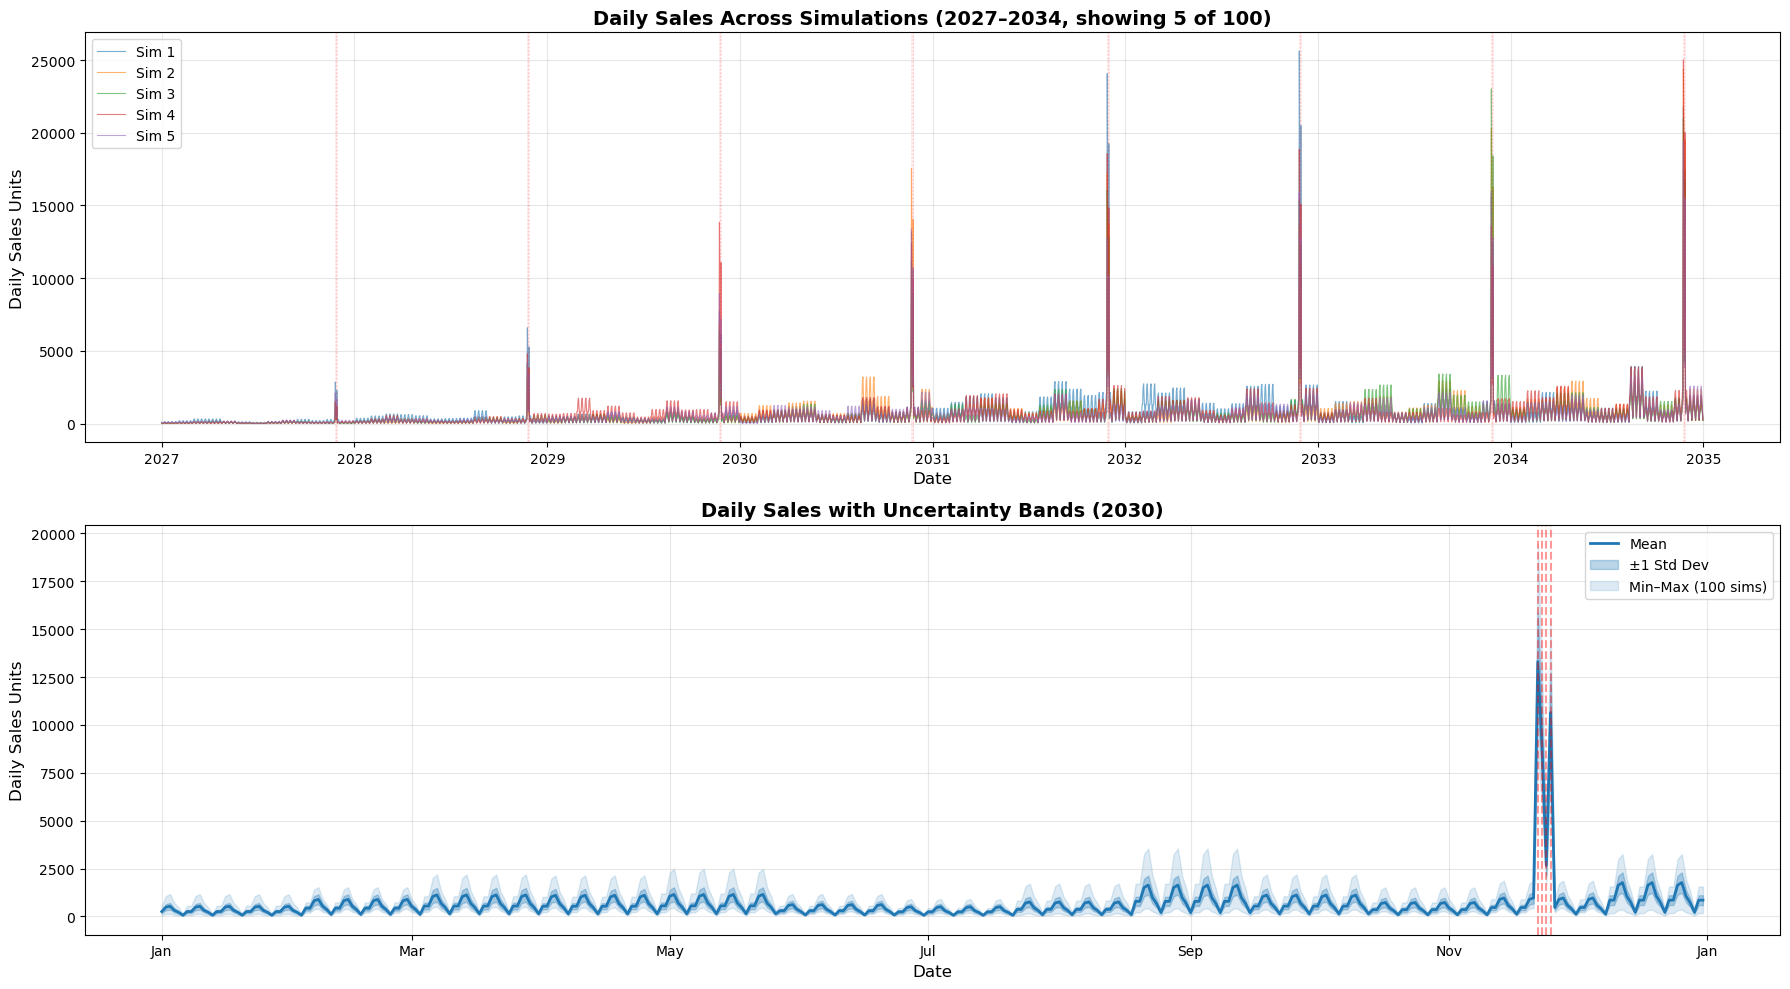

Saved: task1_timeseries_daily_sales.png


In [32]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# ── Plot 1: Daily total sales — first 5 sims for legibility ──
daily_by_sim = (
    viz_df[viz_df['sim'] < 5]
    .groupby(['sim', 'date'])['sales_units']
    .sum().reset_index()
)
for sim_id in range(5):
    d = daily_by_sim[daily_by_sim['sim'] == sim_id]
    axes[0].plot(d['date'], d['sales_units'], alpha=0.6, linewidth=0.8, label=f'Sim {sim_id+1}')

for yr in YEARS:
    for cw_d in sorted(cyber_week_dates(yr)):
        axes[0].axvline(pd.Timestamp(cw_d), color='red', alpha=0.15, linewidth=0.5, linestyle='--')

axes[0].set_title(f'Daily Sales Across Simulations (2027–2034, showing 5 of {N_SIM})',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Daily Sales Units', fontsize=12)
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# ── Plot 2: 2030 confidence band across all N_SIM sims ──
daily_2030 = (
    viz_df[viz_df['year'] == 2030]
    .groupby(['sim', 'date'])['sales_units']
    .sum().reset_index()
)
stats_2030 = (
    daily_2030.groupby('date')['sales_units']
    .agg(['mean', 'std', 'min', 'max']).reset_index()
)

axes[1].plot(stats_2030['date'], stats_2030['mean'],
             color='#1f77b4', linewidth=2, label='Mean')
axes[1].fill_between(stats_2030['date'],
                     stats_2030['mean'] - stats_2030['std'],
                     stats_2030['mean'] + stats_2030['std'],
                     alpha=0.3, color='#1f77b4', label='±1 Std Dev')
axes[1].fill_between(stats_2030['date'],
                     stats_2030['min'], stats_2030['max'],
                     alpha=0.15, color='#1f77b4', label=f'Min–Max ({N_SIM} sims)')

for cw_d in sorted(cyber_week_dates(2030)):
    axes[1].axvline(pd.Timestamp(cw_d), color='red', alpha=0.4, linewidth=1.5, linestyle='--')

axes[1].set_title('Daily Sales with Uncertainty Bands (2030)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Daily Sales Units', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.savefig('../Plots/task1_timeseries_daily_sales.png', dpi=150)
plt.show()
print('Saved: task1_timeseries_daily_sales.png')

### 10.3 Boxplots: Distribution of Daily Sales Across Simulations

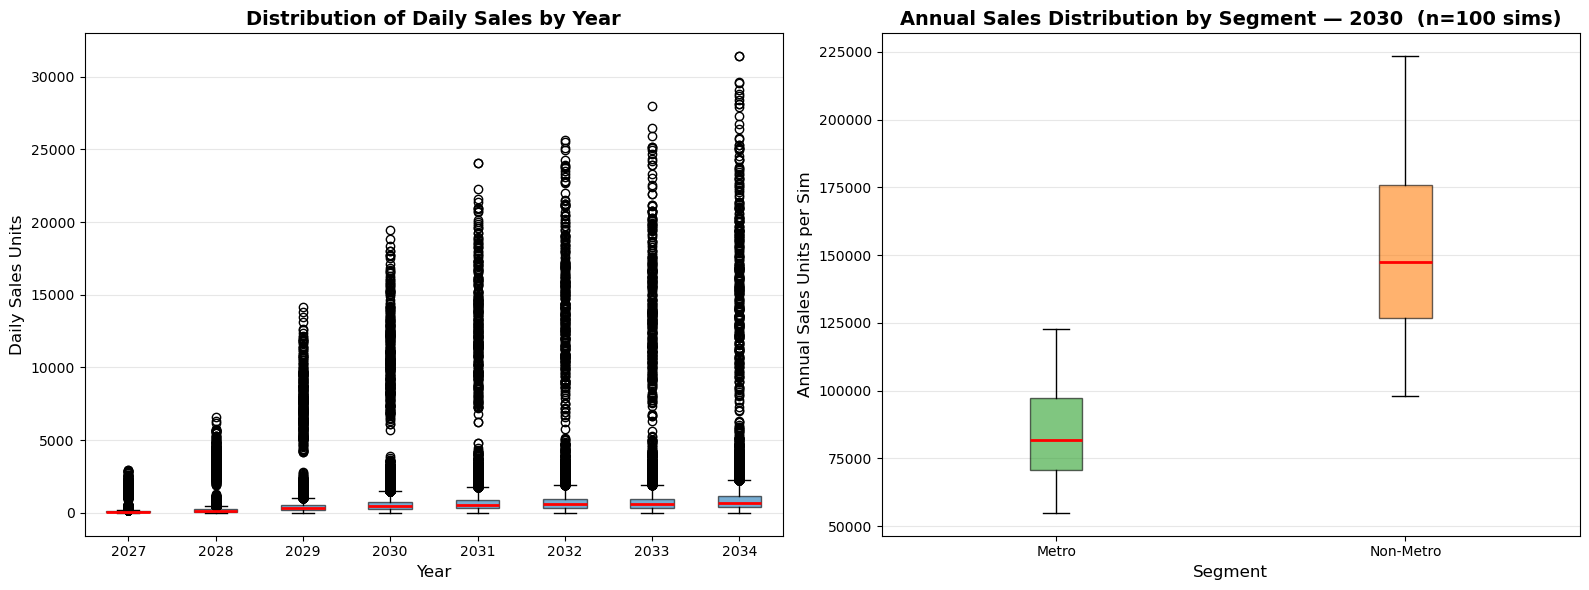

Saved: task1_boxplots_sales_distribution.png


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ── Boxplot 1: Daily total sales distribution by year (all N_SIM sims) ──
daily_by_year = (
    viz_df.groupby(['sim', 'date', 'year'])['sales_units']
    .sum().reset_index()
)
yearly_data  = [daily_by_year[daily_by_year['year'] == yr]['sales_units'].values
                for yr in YEARS]

bp1 = axes[0].boxplot(yearly_data, labels=[str(yr) for yr in YEARS],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))
for patch in bp1['boxes']:
    patch.set_facecolor('#1f77b4')
    patch.set_alpha(0.6)

axes[0].set_title('Distribution of Daily Sales by Year', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Daily Sales Units', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# ── Boxplot 2: Annual sales by segment (2030) across N_SIM sims ──
# Note: daily segment breakdown not in batch files; using annual per-sim segment totals
seg_2030 = segment_summary[segment_summary['year'] == 2030]
segment_data = [seg_2030[seg_2030['segment'] == seg]['sales_units'].values
                for seg in ['Metro', 'Non-Metro']]

bp2 = axes[1].boxplot(segment_data, labels=['Metro', 'Non-Metro'],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))
for patch, color in zip(bp2['boxes'], ['#2ca02c', '#ff7f0e']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_title(f'Annual Sales Distribution by Segment — 2030  (n={N_SIM} sims)',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Segment', fontsize=12)
axes[1].set_ylabel('Annual Sales Units per Sim', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../Plots/task1_boxplots_sales_distribution.png', dpi=150)
plt.show()
print('Saved: task1_boxplots_sales_distribution.png')

### 10.4 Product Line Analysis

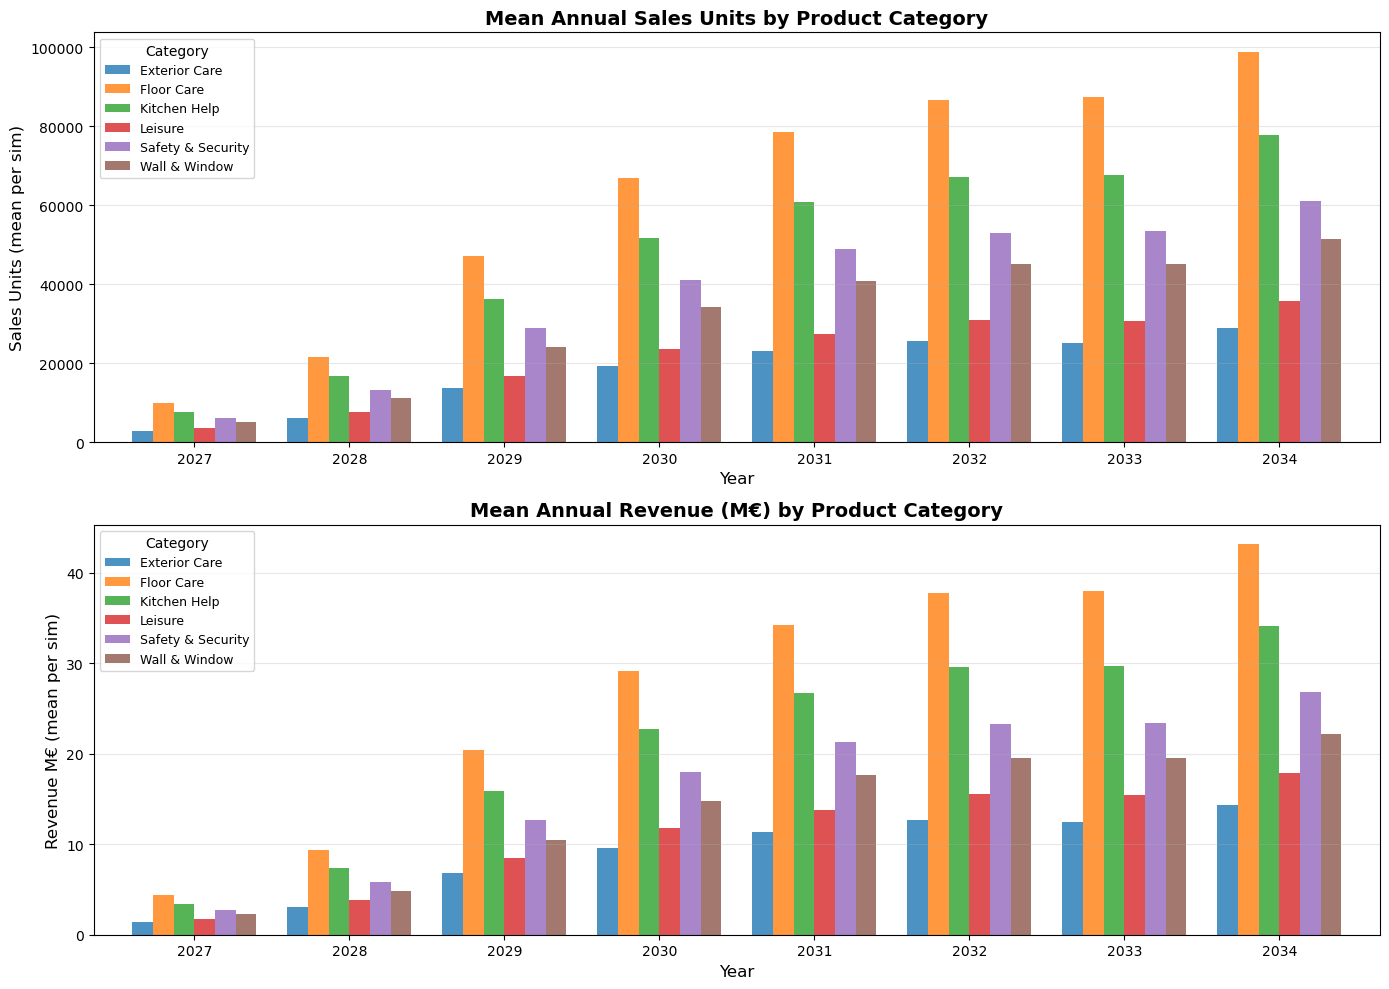

Saved: task1_product_category_analysis.png


In [34]:
# viz_df already carries Category and revenue (computed in loading cell)
category_agg = (
    viz_df.groupby(['year', 'Category'])
    .agg(sales_units=('sales_units', 'sum'),
         revenue    =('revenue',     'sum'))
    .reset_index()
)
# Divide by N_SIM to get mean-per-sim values
category_agg['sales_units'] /= N_SIM
category_agg['revenue']     /= N_SIM

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

category_pivot = category_agg.pivot_table(index='year', columns='Category', values='sales_units')
category_pivot.plot(kind='bar', ax=axes[0], stacked=False, alpha=0.8, width=0.8)
axes[0].set_title('Mean Annual Sales Units by Product Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Sales Units (mean per sim)', fontsize=12)
axes[0].legend(title='Category', loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

revenue_pivot = (
    category_agg.pivot_table(index='year', columns='Category', values='revenue') / 1e6
)
revenue_pivot.plot(kind='bar', ax=axes[1], stacked=False, alpha=0.8, width=0.8)
axes[1].set_title('Mean Annual Revenue (M€) by Product Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Revenue M€ (mean per sim)', fontsize=12)
axes[1].legend(title='Category', loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../Plots/task1_product_category_analysis.png', dpi=150)
plt.show()
print('Saved: task1_product_category_analysis.png')

### 10.5 Model Tier Revenue Analysis

Country-level breakdown is not stored in batch files.  
Replaced with **model-tier** (10 / 20 / 30 / 50) revenue and market-share analysis.

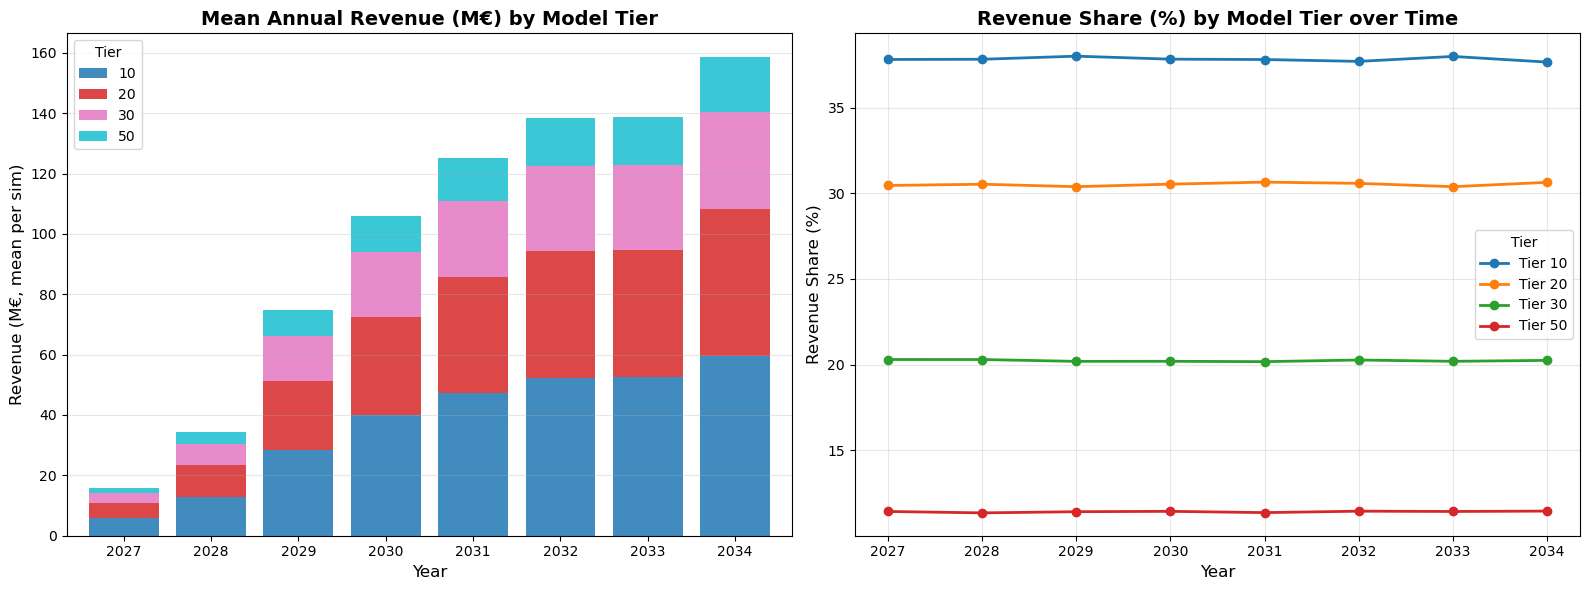

Saved: task1_model_tier_analysis.png


In [35]:
# viz_df['tier'] already extracted in the loading cell
tier_agg = (
    viz_df.groupby(['year', 'tier'])
    .agg(sales_units=('sales_units', 'sum'),
         revenue    =('revenue',     'sum'))
    .reset_index()
)
tier_agg['sales_units'] /= N_SIM
tier_agg['revenue']     /= N_SIM

total_rev_yr = tier_agg.groupby('year')['revenue'].sum().rename('total_rev')
tier_agg = tier_agg.join(total_rev_yr, on='year')
tier_agg['rev_pct'] = tier_agg['revenue'] / tier_agg['total_rev'] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Stacked revenue by tier per year
tier_rev_pivot = tier_agg.pivot_table(index='year', columns='tier', values='revenue') / 1e6
tier_rev_pivot.plot(kind='bar', ax=axes[0], stacked=True, alpha=0.85, width=0.8, colormap='tab10')
axes[0].set_title('Mean Annual Revenue (M€) by Model Tier', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Revenue (M€, mean per sim)', fontsize=12)
axes[0].legend(title='Tier', loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot 2: Revenue share (%) by tier over time
for tier_val in sorted(tier_agg['tier'].unique()):
    sub = tier_agg[tier_agg['tier'] == tier_val]
    axes[1].plot(sub['year'], sub['rev_pct'], marker='o', linewidth=2, label=f'Tier {tier_val}')

axes[1].set_title('Revenue Share (%) by Model Tier over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Revenue Share (%)', fontsize=12)
axes[1].legend(title='Tier', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../Plots/task1_model_tier_analysis.png', dpi=150)
plt.show()
print('Saved: task1_model_tier_analysis.png')

### 10.6 Key Insights & Summary

In [36]:
print('='*80)
print('KEY INSIGHTS FROM SIMULATION (Task 1.6)')
print('='*80)

# ── Totals (mean per sim) ──────────────────────────────────────────────────
total_sales   = viz_df['sales_units'].sum() / N_SIM
total_revenue = viz_df['revenue'].sum()     / N_SIM / 1e6
total_demand  = annual_summary['demand_units'].sum() / N_SIM
avg_conversion = total_sales / total_demand * 100

print('\n1. OVERALL MARKET PERFORMANCE (2027-2034)')
print('-' * 80)
print(f'   Total Demand (mean):    {total_demand:>12,.0f} units')
print(f'   Total Sales (mean):     {total_sales:>12,.0f} units')
print(f'   Lost Sales (mean):      {total_demand-total_sales:>12,.0f} units  ({100-avg_conversion:.1f}% loss)')
print(f'   Average Conversion:     {avg_conversion:>11.1f}%')
print(f'   Total Revenue (mean):   €{total_revenue:>10,.1f}M')
print(f'   Avg Revenue/Year:       €{total_revenue/8:>10,.1f}M')

# ── OTD Impact ──────────────────────────────────────────────────────────────
print('\n2. YEAR-SPECIFIC OTD IMPROVEMENT IMPACT')
print('-' * 80)
print(f'\n{otd_pivot.to_string()}')
conv_change = segment_pivot.iloc[-1].mean() - segment_pivot.iloc[0].mean()
print(f'\n   Conversion improvement 2027→2034: {conv_change:+.1f} ppt')

# ── Segment Performance ──────────────────────────────────────────────────────
print('\n3. SEGMENT PERFORMANCE COMPARISON')
print('-' * 80)
for seg in ['Metro', 'Non-Metro']:
    sub = segment_summary[segment_summary['segment'] == seg]
    avg_sales  = sub['sales_units'].sum() / N_SIM
    avg_demand = sub['demand_units'].sum() / N_SIM
    avg_conv   = sub['conversion_pct'].mean()
    avg_otd    = sub['otd_days'].mean()
    print(f'   {seg}:  sales={avg_sales:,.0f}  conv={avg_conv:.1f}%  OTD={avg_otd:.2f} days')

# ── Cyber Week ───────────────────────────────────────────────────────────────
print('\n4. CYBER WEEK IMPACT')
print('-' * 80)
cw_sales   = viz_df[viz_df['is_cyber_week']]['sales_units'].sum() / N_SIM
cw_revenue = viz_df[viz_df['is_cyber_week']]['revenue'].sum()     / N_SIM / 1e6
print(f'   Cyber Week Sales (mean):   {cw_sales:>10,.0f} units  ({cw_sales/total_sales*100:.1f}% of annual)')
print(f'   Cyber Week Revenue (mean): €{cw_revenue:>8,.1f}M  ({cw_revenue/total_revenue*100:.1f}% of annual)')
print(f'   Note: {CYBER_PRICE_DISCOUNT*100:.0f}% price discount applied during Cyber Week')

# ── Product Category ─────────────────────────────────────────────────────────
print('\n5. TOP PERFORMING PRODUCT CATEGORIES')
print('-' * 80)
cat_totals = (
    viz_df.groupby('Category')['sales_units'].sum()
    .div(N_SIM).sort_values(ascending=False)
)
for cat, sales in cat_totals.head(3).items():
    print(f'   {cat:25}  {sales:>10,.0f} units  ({sales/total_sales*100:.1f}%)')

# ── Simulation Variability ────────────────────────────────────────────────────
print('\n6. SIMULATION VARIABILITY (100 reps)')
print('-' * 80)
ann_stats_yr = (
    annual_summary.groupby('year')
    .agg(s_mean=('sales_units','mean'), s_std=('sales_units','std'),
         r_mean=('revenue','mean'),     r_std=('revenue','std'))
    .reset_index()
)
cv_sales   = (ann_stats_yr['s_std'] / ann_stats_yr['s_mean'] * 100).mean()
cv_revenue = (ann_stats_yr['r_std'] / ann_stats_yr['r_mean'] * 100).mean()
print(f'   CV Sales (mean across years):   {cv_sales:.2f}%')
print(f'   CV Revenue (mean across years): {cv_revenue:.2f}%')

print('\n' + '='*80)
print('SIMULATION COMPLETE — All visualizations saved!')
print('='*80)

KEY INSIGHTS FROM SIMULATION (Task 1.6)

1. OVERALL MARKET PERFORMANCE (2027-2034)
--------------------------------------------------------------------------------
   Total Demand (mean):       1,828,512 units
   Total Sales (mean):        1,766,897 units
   Lost Sales (mean):            61,615 units  (3.4% loss)
   Average Conversion:            96.6%
   Total Revenue (mean):   €     791.5M
   Avg Revenue/Year:       €      98.9M

2. YEAR-SPECIFIC OTD IMPROVEMENT IMPACT
--------------------------------------------------------------------------------

segment  Metro  Non-Metro
year                     
2027      0.37       1.50
2028      0.37       2.58
2029      0.36       2.74
2030      0.46       2.76
2031      0.46       2.76
2032      0.46       2.76
2033      0.46       2.76
2034      0.46       2.76

   Conversion improvement 2027→2034: -1.3 ppt

3. SEGMENT PERFORMANCE COMPARISON
--------------------------------------------------------------------------------
   Metro:  sales=62